In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#pip install -r requirements.txt
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation


from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils


import keras
import tensorflow
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm


import h5py
from keras.models import model_from_json
import pickle

In [3]:
pip freeze > requirements.txt

In [137]:
local_path = '/content/drive/MyDrive/Emotion_Recognition/FER/'

In [138]:
pd.options.mode.chained_assignment = None

#Reading the dataset
dataset = pd.read_csv(local_path + 'fer2013.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [139]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


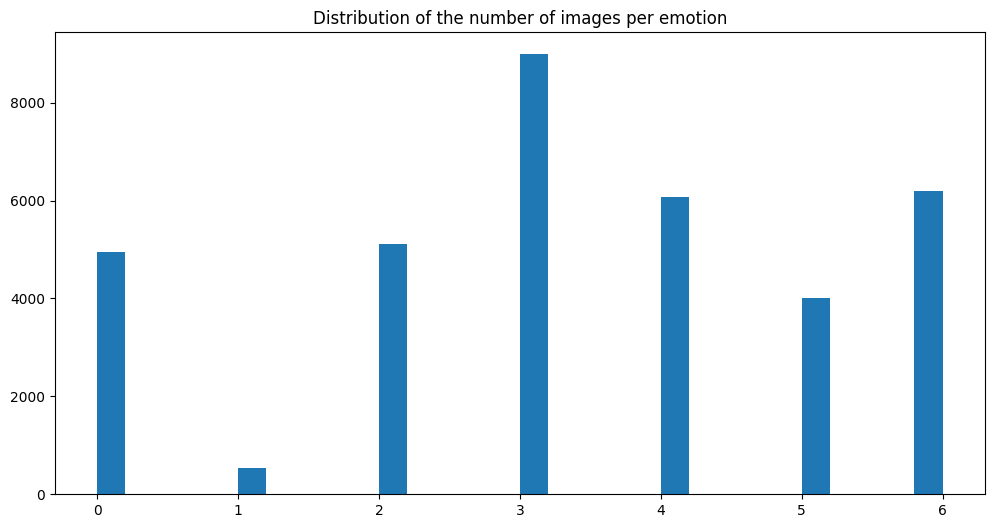

In [140]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

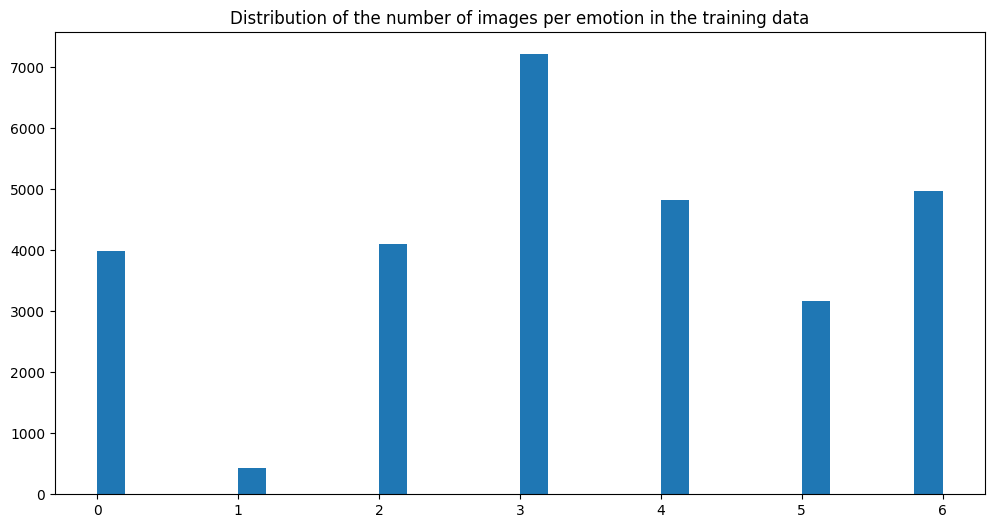

In [141]:
plt.figure(figsize=(12,6))
plt.hist(train['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion in the training data")
plt.show()

In [142]:
train.shape

(28709, 3)

In [143]:
test.shape

(3589, 3)

In [144]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

In [145]:
print(X_train.shape)
print(y_train.shape)

(28709,)
(28709,)


In [146]:
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
print("Before OverSampling, counts of label '1': {} \n".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '2': {} \n".format(sum(y_train == 2)))
print("Before OverSampling, counts of label '3': {} \n".format(sum(y_train == 3)))
print("Before OverSampling, counts of label '4': {} \n".format(sum(y_train == 4)))
print("Before OverSampling, counts of label '5': {} \n".format(sum(y_train == 5)))
print("Before OverSampling, counts of label '6': {} \n".format(sum(y_train == 6)))

Before OverSampling, counts of label '0': 3995
Before OverSampling, counts of label '1': 436 

Before OverSampling, counts of label '2': 4097 

Before OverSampling, counts of label '3': 7215 

Before OverSampling, counts of label '4': 4830 

Before OverSampling, counts of label '5': 3171 

Before OverSampling, counts of label '6': 4965 



In [147]:
#Data-preparation for Over-sampling

# class count
class_count_0, class_count_1, class_count_2, class_count_3, class_count_4, class_count_5, class_count_6 = train['emotion'].value_counts()

# Separate class
class_0 = train[train['emotion'] == 0]
class_1 = train[train['emotion'] == 1]
class_2 = train[train['emotion'] == 2]
class_3 = train[train['emotion'] == 3]
class_4 = train[train['emotion'] == 4]
class_5 = train[train['emotion'] == 5]
class_6 = train[train['emotion'] == 6]

print('class 1:', class_1.shape)


class 1: (436, 3)


In [148]:
#Random Oversampling

average_number = int((class_count_0 + class_count_1 + class_count_2 + class_count_3 + class_count_4 + class_count_5 + class_count_6)/6)
class_1_over = class_1.sample(average_number, replace=True)


In [149]:
#Creating new training dataset with balanced data
train_over = pd.concat([class_1_over, class_0, class_2, class_3, class_4, class_5, class_6], axis=0)

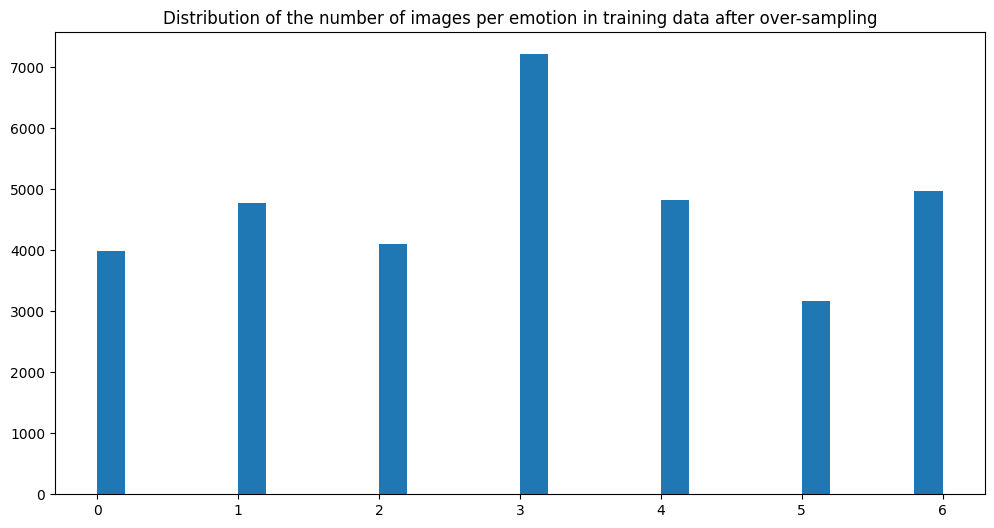

In [150]:
#Plotting the balanced data

plt.figure(figsize=(12,6))
plt.hist(train_over['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion in training data after over-sampling")
plt.show()

In [151]:
train_over.shape

(33057, 3)

In [152]:
test.shape

(3589, 3)

In [153]:
shape_x = 48
shape_y = 48

In [154]:
X_train = train_over.iloc[:, 1].values
y_train = train_over.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (33057, 48, 48, 1) and (33057, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [156]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

In [157]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [158]:
#Defining labels
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

Text(0.5, 1.0, 'Ground Truth : Surprise')

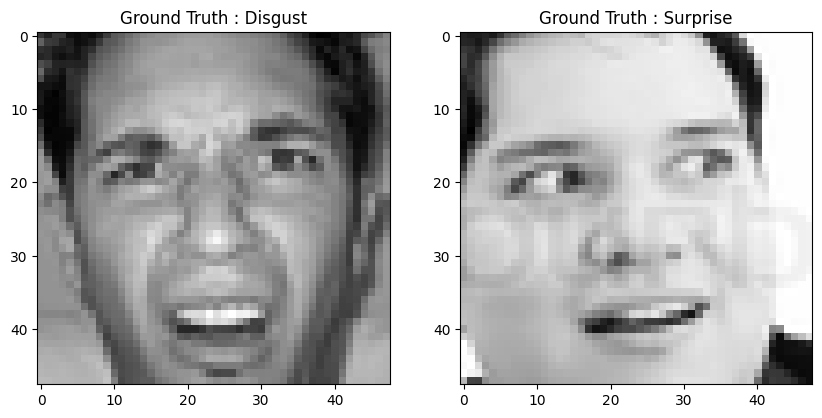

In [172]:
#checking data consistency of the dataset

plt.figure(figsize=[10,5])

# Display an image from training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))

# Display an image from testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[1500,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

In [173]:
def detect_face(frame):

    #Cascade classifier pre-trained model
    cascPath = '/content/drive/MyDrive/Emotion_Recognition/FER/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []

    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])

    return gray, detected_faces, coord

In [174]:
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]

    new_face = []

    for det in detected_face :

        x, y, w, h = det


        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]


        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)

        new_face.append(new_extracted_face)

    return new_face

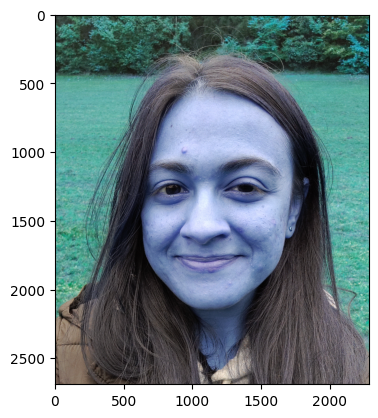

In [175]:
myself = '/content/drive/MyDrive/Emotion_Recognition/FER/myself2.jpg'
myself_face = cv2.imread(myself, cv2.COLOR_BGR2RGB)
plt.imshow(myself_face)

<ipython-input-174-099711bfc7dc>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
<ipython-input-174-099711bfc7dc>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

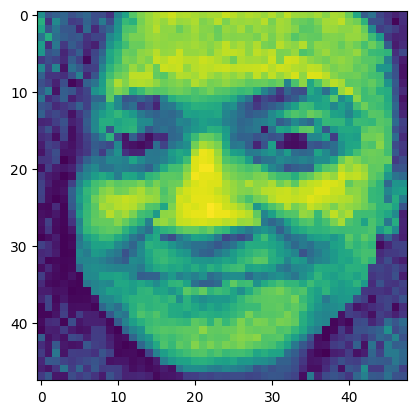

In [176]:
face = extract_face_features(detect_face(myself_face))[0]
plt.imshow(face)

In [177]:
#Xception Model

def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

In [178]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [179]:
def exit_flow(x, num_classes=7) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return x

In [180]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [181]:
xception = Model(inputs, outputs)

In [182]:
xception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 24, 24, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 24, 24, 32)  128         ['conv2d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_36 (Activation)     (None, 24, 24, 32)   0           ['batch_normalization_36[0]

In [183]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 100

In [184]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(test_data, test_labels_one_hot)
)

Epoch 1/100


<ipython-input-184-02fbd2e89199>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = xception.fit_generator(


259/259 [==============================] - 95s 226ms/step - loss: 1.6823 - accuracy: 0.3503 - val_loss: 1.8582 - val_accuracy: 0.2494
Epoch 2/100
259/259 [==============================] - 58s 222ms/step - loss: 1.3938 - accuracy: 0.4765 - val_loss: 2.6132 - val_accuracy: 0.2494
Epoch 3/100
259/259 [==============================] - 58s 223ms/step - loss: 1.2642 - accuracy: 0.5303 - val_loss: 2.2562 - val_accuracy: 0.3714
Epoch 4/100
259/259 [==============================] - 58s 222ms/step - loss: 1.1810 - accuracy: 0.5586 - val_loss: 2.2313 - val_accuracy: 0.3759
Epoch 5/100
259/259 [==============================] - 57s 221ms/step - loss: 1.1194 - accuracy: 0.5823 - val_loss: 3.9337 - val_accuracy: 0.1519
Epoch 6/100
259/259 [==============================] - 57s 222ms/step - loss: 1.0788 - accuracy: 0.5973 - val_loss: 2.6895 - val_accuracy: 0.3605
Epoch 7/100
259/259 [==============================] - 58s 222ms/step - loss: 1.0393 - accuracy: 0.6151 - val_loss: 4.6458 - val_accurac

Text(0.5, 1.0, 'Accuracy Curves')

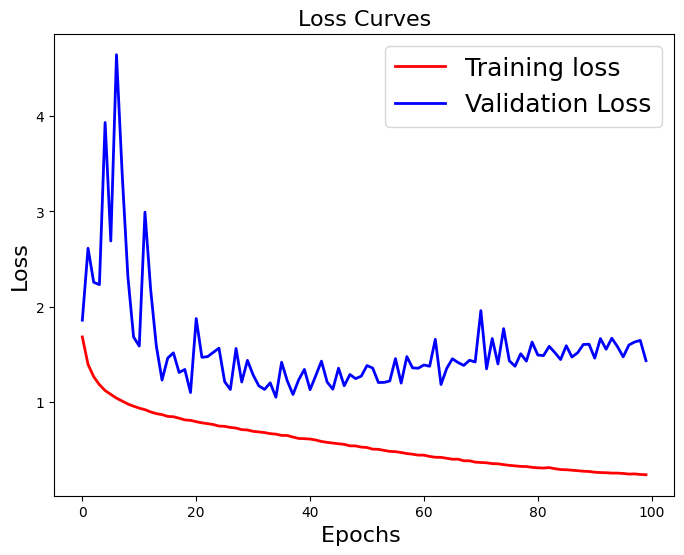

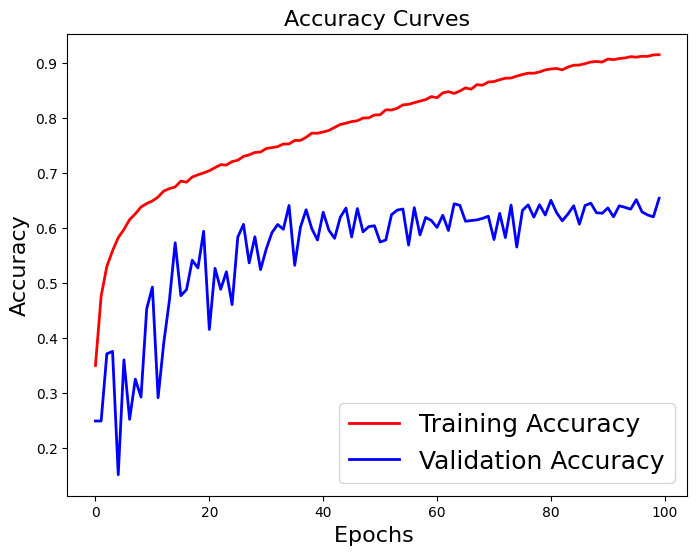

In [185]:
#Plotting accuracy and loss curves for the model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [188]:
#saving the model weights
json_string = xception.to_json()
xception.save_weights(local_path + 'savedmodels/model_3.h5')
open(local_path + 'savedmodels/model_3.json', 'w').write(json_string)
#model.save_weights(local_path + 'savedmodels/Emotion_Face_Detection_Model.h5')

73228

In [189]:
with open(local_path + 'savedmodels/model_3.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights(local_path + 'savedmodels/model_3.h5')
print("Loaded model from disk")

Loaded model from disk


In [190]:
#Making Prediction

garima = '/content/drive/MyDrive/Emotion_Recognition/FER/test_image1.jpg'
garima_face = cv2.imread(garima)

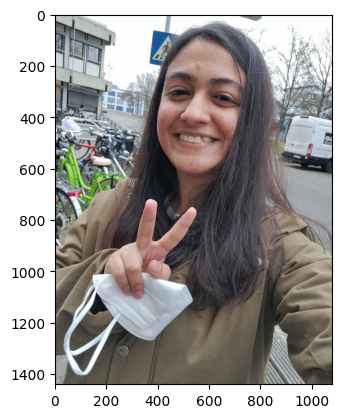

In [191]:
plt.imshow(cv2.cvtColor(garima_face, cv2.COLOR_BGR2RGB))

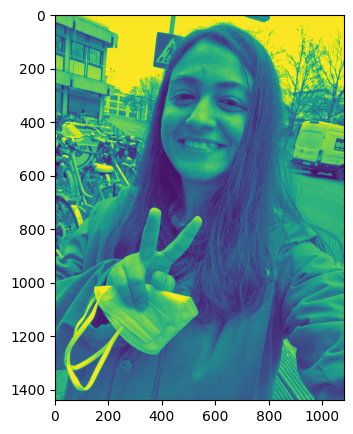

In [195]:
plt.figure(figsize=(5,5))
plt.imshow(detect_face(garima_face)[0])
plt.show()

<ipython-input-174-099711bfc7dc>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
<ipython-input-174-099711bfc7dc>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

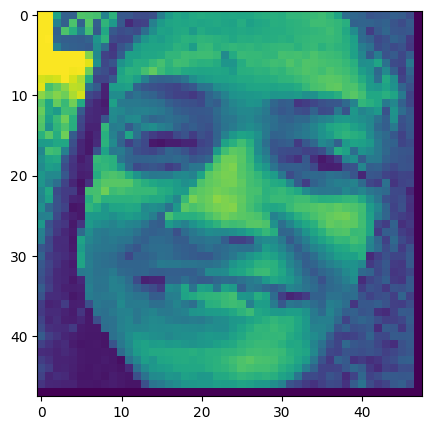

In [196]:
for face in extract_face_features(detect_face(garima_face)) :
    plt.figure(figsize=(5,5))
    plt.imshow(face)
    plt.show()

In [198]:
for face in extract_face_features(detect_face(garima_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)
    print(get_label(result_num))

1/1 [==============================] - 0s 43ms/step
3
Happy


<ipython-input-174-099711bfc7dc>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
<ipython-input-174-099711bfc7dc>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio